In [1]:
import os,sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage import io
from skimage import img_as_ubyte
import skimage.transform
import imgaug as ia
from imgaug import augmenters as iaa
import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/meiker/deep_learning/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/meiker/deep_learning/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/meiker/deep_learning/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/meiker/deep_learning/lib/python3.6/sit

In [2]:
from tensorflow.keras.layers import BatchNormalization

In [3]:
os.chdir('/home/meiker/Escritorio/monca/breca/reto_breca')

In [4]:
df = pd.read_csv("train.csv")

In [5]:
df.values

array([['train_1a', 'arroz'],
       ['train_1b', 'caramelo'],
       ['train_1c', 'jamon'],
       ...,
       ['train_804a', 'nueces'],
       ['train_804b', 'caramelo'],
       ['train_804c', 'cafe']], dtype=object)

In [6]:
df.head()

,image_id,label
0,train_1a,arroz
1,train_1b,caramelo
2,train_1c,jamon
3,train_1d,cafe
4,train_2a,vinagre


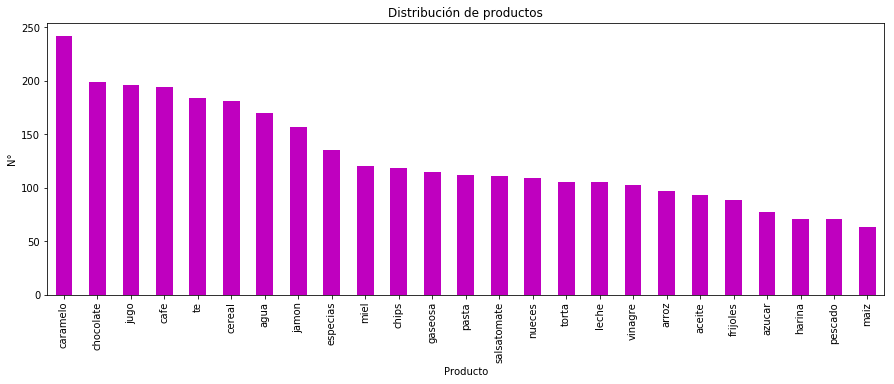

In [7]:
df.label.value_counts().plot(kind='bar',figsize = [15,5],color ='m')
plt.savefig('dis_producto.png')
plt.title('Distribución de productos')
plt.xlabel('Producto')
plt.ylabel('N°')
plt.show()

In [8]:
path = '/home/meiker/Escritorio/monca/breca/reto_breca/train_img/'

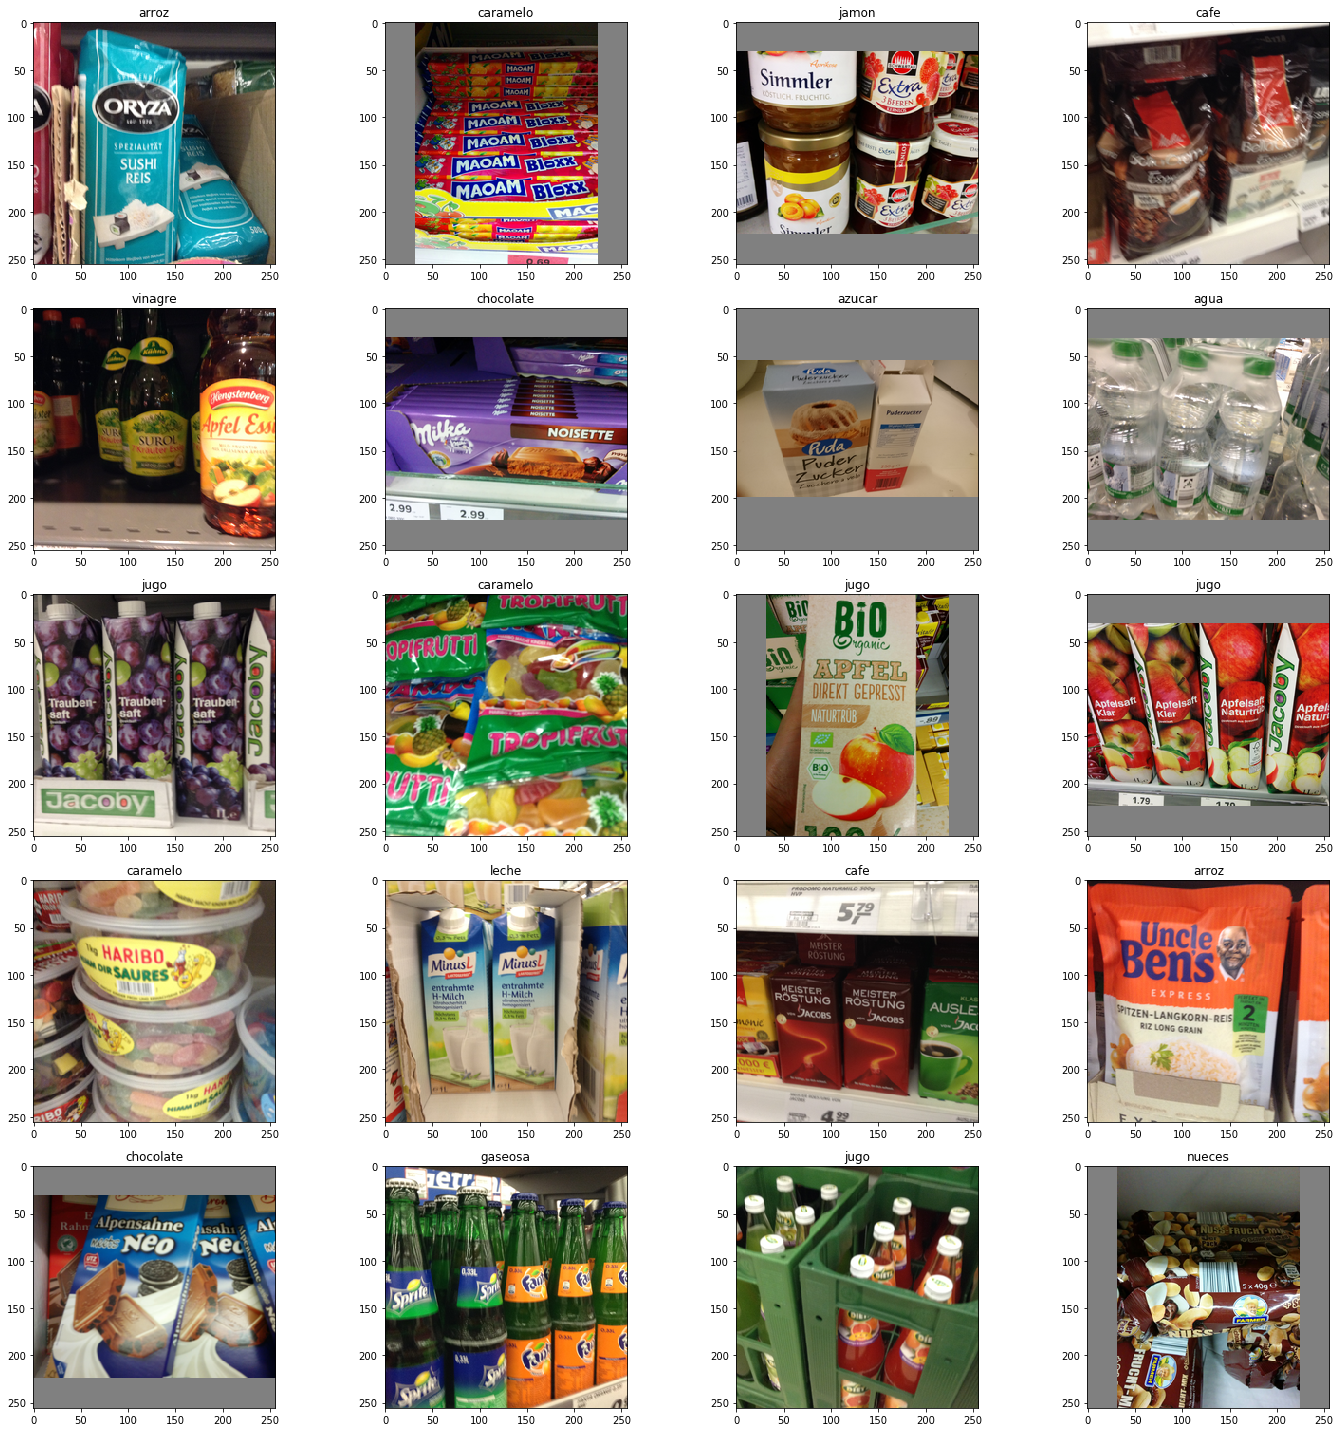

In [9]:

def display_samples(df, columns=4, rows=5):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(20):
        image_path = path + df.loc[i,'image_id']+'.png'
        image_id = df.loc[i,'label']
        img = io.imread(image_path)
        img = np.array(img)
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(df)

In [10]:
def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns,uniques

df, le_encoded_cols,uniques = label_encoder(df, categorical_columns = ['label'])
dic_y = {k:v for v,k in enumerate(uniques)}

In [11]:
dic_y 

{'arroz': 0,
 'caramelo': 1,
 'jamon': 2,
 'cafe': 3,
 'vinagre': 4,
 'chocolate': 5,
 'azucar': 6,
 'agua': 7,
 'jugo': 8,
 'leche': 9,
 'gaseosa': 10,
 'nueces': 11,
 'chips': 12,
 'especias': 13,
 'cereal': 14,
 'frijoles': 15,
 'torta': 16,
 'miel': 17,
 'harina': 18,
 'pasta': 19,
 'salsatomate': 20,
 'te': 21,
 'maiz': 22,
 'aceite': 23,
 'pescado': 24}

In [12]:
from sklearn.cross_validation import train_test_split

def read_train_data(d,imgsize):
    X, Y = [], []
    for img,label in df.values:
        imagen = io.imread(path+r'/'+img+ '.png')
        imagen = img_as_ubyte(skimage.transform.resize(imagen, (imgsize, imgsize)))
        X.append(imagen)
        Y.append(label)
    return np.array(X, np.float32), np.array(Y)

x_train, y_train = read_train_data(df.values,256)
x_train /= 255.

/home/meiker/deep_learning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
def load_data_local_eval(val_split,x_train, y_train):
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, \
        test_size=val_split, random_state=42)
    return (x_train, x_val, y_train, y_val)

x_train, x_val, y_train, y_val = load_data_local_eval(0.2,x_train, y_train)

In [15]:
x_train.shape[1:]

(256, 256, 3)

In [14]:
BATCH_SIZE = 23
checkpoint = 1

base_model = applications.InceptionResNetV2( weights='imagenet', include_top=False, input_shape=x_train.shape[1:])

In [16]:
base_model.output_shape[1:]

(6, 6, 1536)

In [15]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(BatchNormalization())
add_model.add(Dense(256, activation='relu'))
add_model.add(BatchNormalization())
add_model.add(Dropout(0.5))
add_model.add(Dense(np.max(y_train) + 1, activation='softmax'))

base_model.trainable = False 
add_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 55296)             0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 55296)             221184    
_________________________________________________________________
dense (Dense)                (None, 256)               14156032  
_________________________________________________________________
batch_normalization_204 (Bat (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                6425      
Total params: 14,384,665
Trainable params: 14,273,561
Non-trainable params: 111,104
__________________________________________________________

In [16]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

In [23]:
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-5),metrics=['accuracy'])

In [30]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler

checkpointer =  ModelCheckpoint(
    './base.model',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    period=1)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
 )

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
 )

callbacks = [checkpoint,reduce]

In [31]:
train_datagen = ImageDataGenerator()

def train_model(train_datagen, epochs):
    train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
    history = model.fit_generator(
        train_generator,
        validation_data  = (x_val,y_val),
        validation_steps = 100,
        steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
        epochs=epochs,
        verbose = 1,
        callbacks=[checkpointer]
    )
    return history

In [32]:
 history= train_model(train_datagen, 2)

Epoch 1/2
110/111 [============================>.] - ETA: 0s - loss: 4.1764 - acc: 0.0737
Epoch 00001: val_acc improved from -inf to 0.19596, saving model to ./base.model
111/111 [==============================] - 300s 3s/step - loss: 4.1700 - acc: 0.0742 - val_loss: 2.8437 - val_acc: 0.1960
Epoch 2/2
110/111 [============================>.] - ETA: 0s - loss: 2.7722 - acc: 0.2595
Epoch 00002: val_acc improved from 0.19596 to 0.31415, saving model to ./base.model
111/111 [==============================] - 46s 417ms/step - loss: 2.7698 - acc: 0.2591 - val_loss: 2.3779 - val_acc: 0.3142


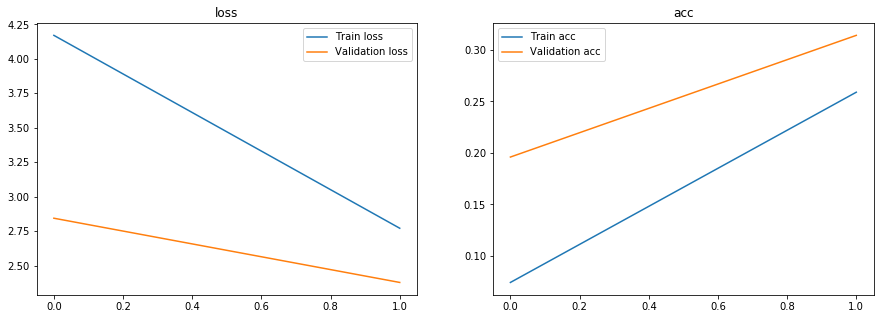

In [33]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
show_final_history(history)

In [21]:
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
 )
train_model(train_datagen, 10)

Epoch 1/10
111/111 [==============================] - 46s 412ms/step - loss: 2.3721 - acc: 0.3777 - val_loss: 1.4455 - val_acc: 0.5801

Epoch 00001: val_acc improved from 0.53966 to 0.58009, saving model to ./base.model
Epoch 2/10
111/111 [==============================] - 45s 410ms/step - loss: 2.0704 - acc: 0.4334 - val_loss: 1.3983 - val_acc: 0.5956

Epoch 00002: val_acc improved from 0.58009 to 0.59565, saving model to ./base.model
Epoch 3/10
111/111 [==============================] - 46s 411ms/step - loss: 1.8885 - acc: 0.4700 - val_loss: 1.3331 - val_acc: 0.6112

Epoch 00003: val_acc improved from 0.59565 to 0.61120, saving model to ./base.model
Epoch 4/10
111/111 [==============================] - 45s 407ms/step - loss: 1.7363 - acc: 0.5176 - val_loss: 1.2687 - val_acc: 0.6205

Epoch 00004: val_acc improved from 0.61120 to 0.62053, saving model to ./base.model
Epoch 5/10
111/111 [==============================] - 45s 408ms/step - loss: 1.6286 - acc: 0.5404 - val_loss: 1.1831 - v

Epoch 1/10
111/111 [==============================] - 45s 409ms/step - loss: 1.2517 - acc: 0.6181 - val_loss: 0.9710 - val_acc: 0.7309

Epoch 00001: val_acc improved from 0.70918 to 0.73095, saving model to ./base.model
Epoch 2/10
111/111 [==============================] - 45s 408ms/step - loss: 1.1668 - acc: 0.6476 - val_loss: 0.9657 - val_acc: 0.7294

Epoch 00002: val_acc did not improve from 0.73095
Epoch 3/10
111/111 [==============================] - 46s 413ms/step - loss: 1.0750 - acc: 0.6758 - val_loss: 0.9655 - val_acc: 0.7294

Epoch 00003: val_acc did not improve from 0.73095
Epoch 4/10
111/111 [==============================] - 45s 408ms/step - loss: 1.0517 - acc: 0.6800 - val_loss: 0.9408 - val_acc: 0.7356

Epoch 00004: val_acc improved from 0.73095 to 0.73561, saving model to ./base.model
Epoch 5/10
111/111 [==============================] - 45s 407ms/step - loss: 0.9797 - acc: 0.6978 - val_loss: 0.9349 - val_acc: 0.7232

Epoch 00005: val_acc did not improve from 0.73561
Ep

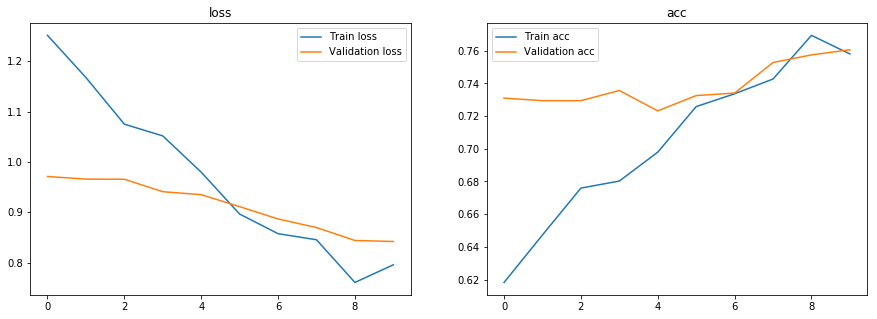

In [22]:
train_datagen = ImageDataGenerator(
        rotation_range=40, 
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
 )

history = train_model(train_datagen, 10)
show_final_history(history)

Epoch 1/30
111/111 [==============================] - 48s 435ms/step - loss: 1.1968 - acc: 0.6449 - val_loss: 0.8557 - val_acc: 0.7512

Epoch 00001: val_acc did not improve from 0.76050
Epoch 2/30
111/111 [==============================] - 48s 434ms/step - loss: 1.1213 - acc: 0.6623 - val_loss: 0.8447 - val_acc: 0.7574

Epoch 00002: val_acc did not improve from 0.76050
Epoch 3/30
111/111 [==============================] - 48s 435ms/step - loss: 1.0379 - acc: 0.6945 - val_loss: 0.8251 - val_acc: 0.7512

Epoch 00003: val_acc did not improve from 0.76050
Epoch 4/30
111/111 [==============================] - 48s 432ms/step - loss: 1.0012 - acc: 0.6979 - val_loss: 0.8004 - val_acc: 0.7543

Epoch 00004: val_acc did not improve from 0.76050
Epoch 5/30
111/111 [==============================] - 48s 433ms/step - loss: 0.9219 - acc: 0.7188 - val_loss: 0.7929 - val_acc: 0.7652

Epoch 00005: val_acc improved from 0.76050 to 0.76516, saving model to ./base.model
Epoch 6/30
111/111 [================

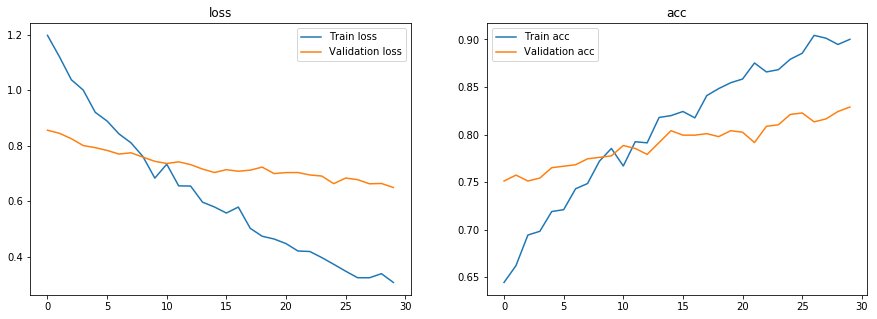

In [23]:
train_datagen = ImageDataGenerator(
        rotation_range=90, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
  )

history = train_model(train_datagen, 30) # epoch 30
show_final_history(history)

Epoch 1/20
111/111 [==============================] - 46s 417ms/step - loss: 0.5517 - acc: 0.8302 - val_loss: 0.6622 - val_acc: 0.8165

Epoch 00001: val_acc did not improve from 0.82893
Epoch 2/20
111/111 [==============================] - 46s 413ms/step - loss: 0.4866 - acc: 0.8465 - val_loss: 0.6581 - val_acc: 0.8274

Epoch 00002: val_acc did not improve from 0.82893
Epoch 3/20
111/111 [==============================] - 45s 407ms/step - loss: 0.4737 - acc: 0.8538 - val_loss: 0.6554 - val_acc: 0.8227

Epoch 00003: val_acc did not improve from 0.82893
Epoch 4/20
111/111 [==============================] - 45s 409ms/step - loss: 0.4690 - acc: 0.8507 - val_loss: 0.6369 - val_acc: 0.8134

Epoch 00004: val_acc did not improve from 0.82893
Epoch 5/20
111/111 [==============================] - 46s 412ms/step - loss: 0.4386 - acc: 0.8603 - val_loss: 0.6107 - val_acc: 0.8320

Epoch 00005: val_acc improved from 0.82893 to 0.83204, saving model to ./base.model
Epoch 6/20
111/111 [================

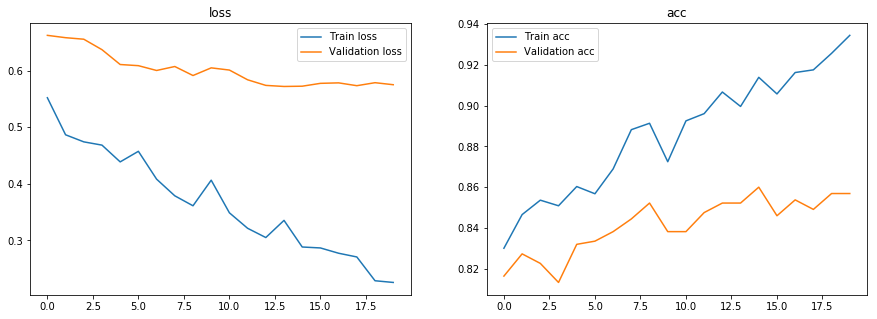

In [24]:
train_datagen = ImageDataGenerator(
        rotation_range=90, 
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.4,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
)
history = train_model(train_datagen, 20)
show_final_history(history)

Epoch 1/20
111/111 [==============================] - 46s 413ms/step - loss: 0.2378 - acc: 0.9310 - val_loss: 0.5864 - val_acc: 0.8631

Epoch 00001: val_acc improved from 0.86003 to 0.86314, saving model to ./base.model
Epoch 2/20
111/111 [==============================] - 46s 417ms/step - loss: 0.2426 - acc: 0.9266 - val_loss: 0.5831 - val_acc: 0.8600

Epoch 00002: val_acc did not improve from 0.86314
Epoch 3/20
111/111 [==============================] - 46s 418ms/step - loss: 0.2238 - acc: 0.9274 - val_loss: 0.5903 - val_acc: 0.8507

Epoch 00003: val_acc did not improve from 0.86314
Epoch 4/20
111/111 [==============================] - 47s 421ms/step - loss: 0.2321 - acc: 0.9265 - val_loss: 0.5827 - val_acc: 0.8460

Epoch 00004: val_acc did not improve from 0.86314
Epoch 5/20
111/111 [==============================] - 47s 422ms/step - loss: 0.2085 - acc: 0.9391 - val_loss: 0.5522 - val_acc: 0.8647

Epoch 00005: val_acc improved from 0.86314 to 0.86470, saving model to ./base.model
Ep

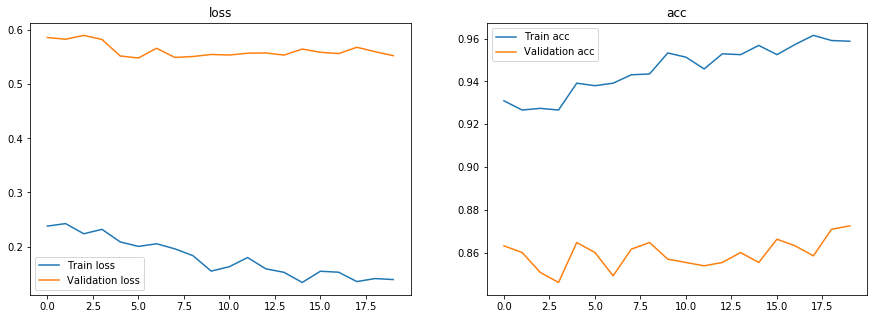

In [25]:
ia.seed(1)
sometimes = lambda aug: iaa.Sometimes(0.3, aug)

seq = iaa.Sequential([
  iaa.Fliplr(0.5),
  iaa.Fliplr(0.5),
  iaa.Affine(
      scale={"x": (0.7, 1.3), "y": (0.7, 1.3)},
      translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)},
      rotate=(-60, 60),
      shear=(-30, 30),
      order=[0, 1],
      mode='reflect',
  ),
])

def image_augment(i):
  images = np.expand_dims(i, 0)
  images = seq.augment_images(images)
  return images[0]

train_datagen = ImageDataGenerator(preprocessing_function=image_augment)
history = train_model(train_datagen, 20)
show_final_history(history)

Epoch 1/30
111/111 [==============================] - 46s 416ms/step - loss: 1.6937 - acc: 0.6104 - val_loss: 0.8123 - val_acc: 0.8165

Epoch 00001: val_acc did not improve from 0.87247
Epoch 2/30
111/111 [==============================] - 46s 414ms/step - loss: 1.4671 - acc: 0.6170 - val_loss: 0.7837 - val_acc: 0.8336

Epoch 00002: val_acc did not improve from 0.87247
Epoch 3/30
111/111 [==============================] - 46s 415ms/step - loss: 1.3541 - acc: 0.6417 - val_loss: 0.8616 - val_acc: 0.8258

Epoch 00003: val_acc did not improve from 0.87247
Epoch 4/30
111/111 [==============================] - 45s 408ms/step - loss: 1.3678 - acc: 0.6326 - val_loss: 0.8018 - val_acc: 0.8351

Epoch 00004: val_acc did not improve from 0.87247
Epoch 5/30
111/111 [==============================] - 46s 414ms/step - loss: 1.3569 - acc: 0.6316 - val_loss: 0.7946 - val_acc: 0.8305

Epoch 00005: val_acc did not improve from 0.87247
Epoch 6/30
111/111 [==============================] - 46s 410ms/step -

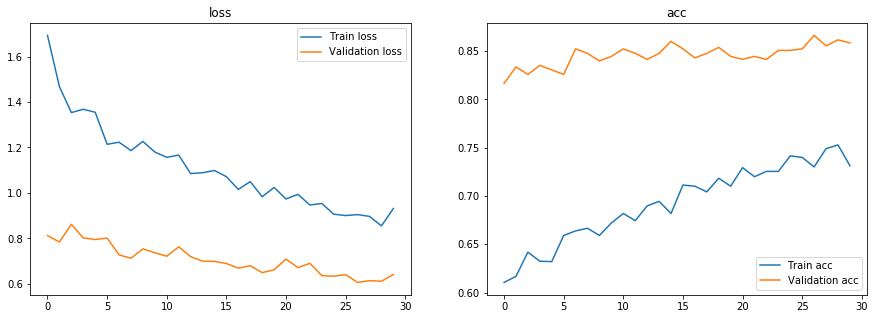

In [26]:
seq = iaa.Sequential([
  iaa.Fliplr(0.5),
  iaa.Fliplr(0.5),
  iaa.Affine(
      scale={"x": (0.35, 2.1), "y": (0.35, 2.1)},
      translate_percent={"x": (-0.65, 0.65), "y": (-0.65, 0.65)},
      rotate=(-90, 90),
      shear=(-70, 70),
      order=[0, 1],
      mode='reflect',
  ),
])

train_datagen = ImageDataGenerator(preprocessing_function=image_augment)
history = train_model(train_datagen, 30)
show_final_history(history)

Epoch 1/20
111/111 [==============================] - 45s 409ms/step - loss: 0.2292 - acc: 0.9283 - val_loss: 0.5656 - val_acc: 0.8756

Epoch 00001: val_acc improved from 0.87247 to 0.87558, saving model to ./base.model
Epoch 2/20
111/111 [==============================] - 46s 412ms/step - loss: 0.2264 - acc: 0.9316 - val_loss: 0.5504 - val_acc: 0.8663

Epoch 00002: val_acc did not improve from 0.87558
Epoch 3/20
111/111 [==============================] - 45s 409ms/step - loss: 0.2186 - acc: 0.9308 - val_loss: 0.5339 - val_acc: 0.8709

Epoch 00003: val_acc did not improve from 0.87558
Epoch 4/20
111/111 [==============================] - 46s 412ms/step - loss: 0.2024 - acc: 0.9362 - val_loss: 0.5281 - val_acc: 0.8725

Epoch 00004: val_acc did not improve from 0.87558
Epoch 5/20
111/111 [==============================] - 46s 414ms/step - loss: 0.2126 - acc: 0.9383 - val_loss: 0.5227 - val_acc: 0.8694

Epoch 00005: val_acc did not improve from 0.87558
Epoch 6/20
111/111 [================

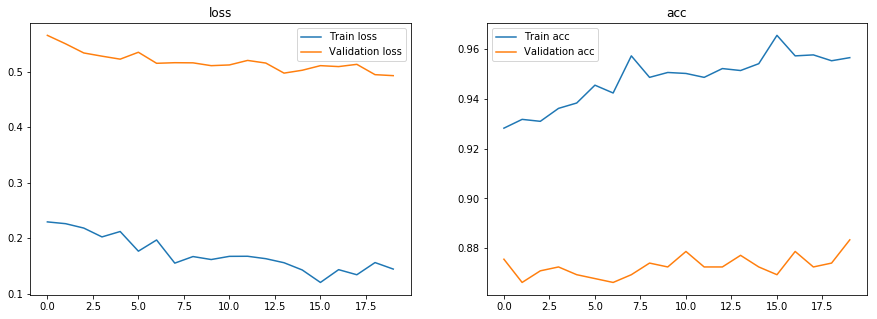

In [27]:
seq = iaa.Sequential([
  iaa.Fliplr(0.5),
  iaa.Fliplr(0.5),
  iaa.Affine(
      scale={"x": (0.6, 1.5), "y": (0.6, 1.5)},
      translate_percent={"x": (-0.4, 0.4), "y": (-0.4, 0.4)},
      rotate=(-90, 90),
      shear=(-40, 40),
      order=[0, 1],
      mode='reflect',
  ),
])

train_datagen = ImageDataGenerator(preprocessing_function=image_augment)
history = train_model(train_datagen, 20)
show_final_history(history)

Epoch 1/30
111/111 [==============================] - 46s 417ms/step - loss: 0.3090 - acc: 0.9097 - val_loss: 0.5180 - val_acc: 0.8802

Epoch 00001: val_acc did not improve from 0.88336
Epoch 2/30
111/111 [==============================] - 46s 413ms/step - loss: 0.2667 - acc: 0.9148 - val_loss: 0.5146 - val_acc: 0.8787

Epoch 00002: val_acc did not improve from 0.88336
Epoch 3/30
111/111 [==============================] - 45s 408ms/step - loss: 0.2988 - acc: 0.9105 - val_loss: 0.5218 - val_acc: 0.8771

Epoch 00003: val_acc did not improve from 0.88336
Epoch 4/30
111/111 [==============================] - 46s 410ms/step - loss: 0.2566 - acc: 0.9201 - val_loss: 0.5289 - val_acc: 0.8694

Epoch 00004: val_acc did not improve from 0.88336
Epoch 5/30
111/111 [==============================] - 46s 414ms/step - loss: 0.2656 - acc: 0.9189 - val_loss: 0.5242 - val_acc: 0.8709

Epoch 00005: val_acc did not improve from 0.88336
Epoch 6/30
111/111 [==============================] - 45s 409ms/step -

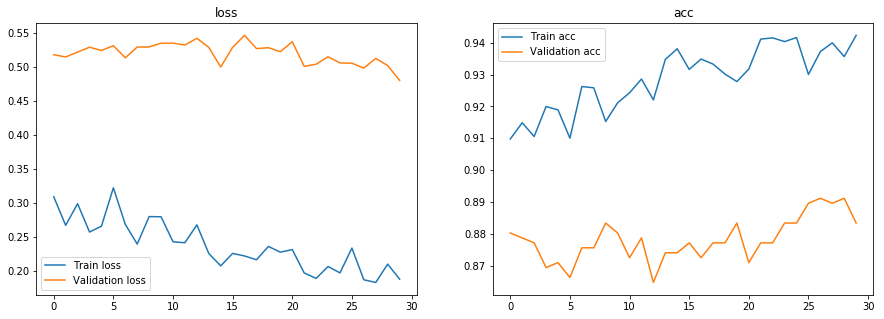

In [28]:
seq = iaa.Sequential([
  iaa.Fliplr(0.5),
  iaa.Fliplr(0.5),
  iaa.Affine(
      scale={"x": (0.5, 1.7), "y": (0.5, 1.7)},
      translate_percent={"x": (-0.5, 0.5), "y": (-0.5, 0.5)},
      rotate=(-90, 90),
      shear=(-50, 50),
      order=[0, 1],
      mode='reflect',
  ),
])
train_datagen = ImageDataGenerator(preprocessing_function=image_augment)
history = train_model(train_datagen, 30)
show_final_history(history)

Epoch 1/20
111/111 [==============================] - 45s 408ms/step - loss: 0.3507 - acc: 0.8980 - val_loss: 0.4904 - val_acc: 0.8911

Epoch 00001: val_acc did not improve from 0.89114
Epoch 2/20
111/111 [==============================] - 45s 409ms/step - loss: 0.3761 - acc: 0.8927 - val_loss: 0.5089 - val_acc: 0.8865

Epoch 00002: val_acc did not improve from 0.89114
Epoch 3/20
111/111 [==============================] - 45s 409ms/step - loss: 0.3158 - acc: 0.9061 - val_loss: 0.4873 - val_acc: 0.8896

Epoch 00003: val_acc did not improve from 0.89114
Epoch 4/20
111/111 [==============================] - 45s 409ms/step - loss: 0.3341 - acc: 0.9019 - val_loss: 0.5069 - val_acc: 0.8834

Epoch 00004: val_acc did not improve from 0.89114
Epoch 5/20
111/111 [==============================] - 46s 413ms/step - loss: 0.3381 - acc: 0.8997 - val_loss: 0.5040 - val_acc: 0.8865

Epoch 00005: val_acc did not improve from 0.89114
Epoch 6/20
111/111 [==============================] - 47s 420ms/step -

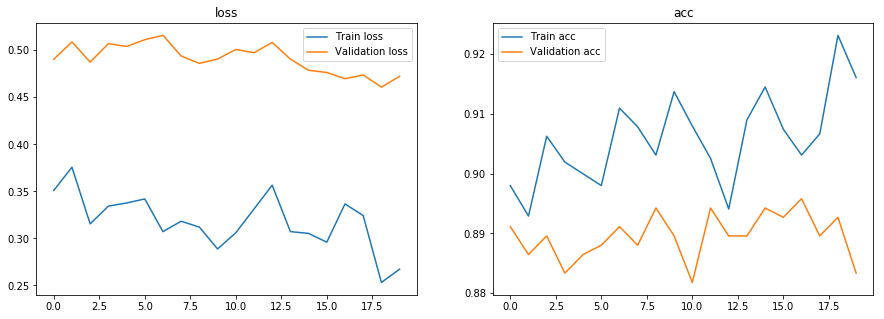

In [29]:
seq = iaa.Sequential([
  iaa.Fliplr(0.5),
  iaa.Fliplr(0.5),
  iaa.Affine(
      scale={"x": (0.45, 1.9), "y": (0.45, 1.9)},
      translate_percent={"x": (-0.55, 0.55), "y": (-0.55, 0.55)},
      rotate=(-90, 90),
      shear=(-60, 60),
      order=[0, 1],
      mode='reflect',
  ),
])

history = train_model(train_datagen, 20)
show_final_history(history)

In [31]:

model.save('modelo_Inception.h5')
model.save_weights('pesos_Inception.h5')


In [32]:
model_json = model.to_json()
with open('modelo_Inception.json', 'w') as json_file:
    json_file.write(model_json)

### Se obtiene un modelo alrededor de 0.89, sin la partición de la data se podría aumentar la puntuación.